In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
from statsmodels.tools import add_constant

In [218]:
def regressHart(y, X, Z, **kwargs):
    n = len(y)
    if n != X.shape[0]:
        raise ValueError('Size mismatch')
    maxiterdef = 10000
    toldef = 1e-08
    test=0
    options = dict(
        intercept=True,
        maxiter=maxiterdef,
        type='art',
        initialbeta=None, # shall be array of shape (n_features, ) for single target regression
        initialgamma=None,
        tol=toldef,
        nocheck=False,
        msgiter=0,
        test=test
    )
    test = options['test']
    reg = LinearRegression(fit_intercept=options['intercept'])
    # number of predictors
    if options['intercept']:
        p = X.shape[1] + 1
    else:
        p = X.shape[1]
    reg_results0 = reg.fit(X, y)
    b0 = np.c_[reg_results0.intercept_, reg_results0.coef_] # b0 is array of shape (n_features, ) for single target regression
    r = y - reg_results0.predict(X)
    oldbeta = b0
    sigma2 = r.T @ r / (n)
    # loglikelihood of residual
    logL_R = n * (1 + np.log(sigma2))
    #  Initialization of gamma
    #  Z = n-by-r matrix which contains the explanatory variables for
    #  heteroskedasticity
    Z_ = Z.copy
    # if options['intercept']:
    #     Z_ = add_constant(Z_)
    response_gamma0 = n * np.square(r) / np.sum(np.square(r)) - 1
    reg_gamma = reg.fit(Z, response_gamma0)
    gamma0 = np.c_[reg_gamma.intercept_, reg_gamma.coef_]
    # gamma
    oldgamma = gamma0
    # tolerance
    tol = options['tol']
    cont = 1
    iter = 0
    maxiter = options['maxiter']
    delt = 1
    th = 8
    dold = np.c_[oldbeta, oldgamma]
    print(f'{dold}')
    while (cont == 1) & (iter < maxiter):
        iter = iter + 1
        if options['intercept']:
            Zoldgamma = (np.c_[np.repeat(1, n), Z] @ oldgamma.T).flatten()
        Zoldgamma[Zoldgamma < -th] = -th
        Zoldgamma[Zoldgamma > th] = th
        expZgamma = np.exp(Zoldgamma)
        omegahat = 1 + expZgamma
        sqrtweight = np.sqrt(omegahat)
        reg_new = reg.fit(X, y, sample_weight=omegahat)
        y_new = reg_new.predict(X)
        newbeta = np.c_[reg_new.intercept_, reg_new.coef_]
        newres2 = np.square(sqrtweight * (y - y_new))
        newsigma2 = np.sum(newres2) / (n)
        Qweights = expZgamma / (1 + expZgamma)
        Zq = Z * Qweights.reshape(-1, 1)
        newres2ori = y - y_new
        yq = newres2ori / (newsigma2 * (1 + expZgamma))
        reg_q = reg.fit(Zq, yq)
        gamma_q = np.c_[reg_q.intercept_, reg_q.coef_]
        newgamma = oldgamma + gamma_q * delt
        dnew = np.c_[newbeta, newgamma]
        print(f'{dnew}')
        if (np.sum(np.square(dnew - dold)) / np.sum(np.square(dold))) > tol:
            cont = 1
            oldgamma = newgamma
            dold=dnew
        else:
            cont = 0
    return y_new

In [249]:
def regressHart(y, X, Z, **kwargs):
    n = len(y)
    if n != X.shape[0]:
        raise ValueError('Size mismatch')
    maxiterdef = 10000
    toldef = 1e-12
    test=0
    options = dict(
        intercept=True,
        maxiter=maxiterdef,
        type='art',
        initialbeta=None, # shall be array of shape (n_features, ) for single target regression
        initialgamma=None,
        tol=toldef,
        nocheck=False,
        msgiter=0,
        test=test
    )
    test = options['test']
    reg = LinearRegression(fit_intercept=options['intercept'])
    # number of predictors
    if options['intercept']:
        p = X.shape[1] + 1
    else:
        p = X.shape[1]
    reg_results0 = reg.fit(X, y)
    b0 = np.c_[reg_results0.intercept_, reg_results0.coef_] # b0 is array of shape (n_features, ) for single target regression
    r = y - reg_results0.predict(X)
    oldbeta = b0
    sigma2 = r.T @ r / (n)
    # loglikelihood of residual
    logL_R = n * (1 + np.log(sigma2))
    #  Initialization of gamma
    #  Z = n-by-r matrix which contains the explanatory variables for
    #  heteroskedasticity
    Z_ = Z.copy
    # if options['intercept']:
    #     Z_ = add_constant(Z_)
    response_gamma0 = n * np.square(r) / np.sum(np.square(r)) - 1
    reg_gamma = reg.fit(Z, response_gamma0)
    gamma0 = np.c_[reg_gamma.intercept_, reg_gamma.coef_]
    # gamma
    oldgamma = gamma0
    # tolerance
    tol = options['tol']
    cont = 1
    iter = 0
    maxiter = options['maxiter']
    delt = 0.5
    th = 8
    dold = np.c_[oldbeta, oldgamma]
    print(f'{dold}')
    while (cont == 1) & (iter < maxiter):
        iter = iter + 1
        if options['intercept']:
            Zoldgamma = (np.c_[np.repeat(1, n), Z] @ oldgamma.T).flatten()
        # Zoldgamma[Zoldgamma < -th] = -th
        # Zoldgamma[Zoldgamma > th] = th
        expZgamma = np.exp(Zoldgamma)
        omegahat = 1 + expZgamma
        weight = np.power(omegahat, -1)
        sqrtweight = np.sqrt(weight)
        reg_new = reg.fit(X, y, sample_weight=weight)
        y_new = reg_new.predict(X)
        newbeta = np.c_[reg_new.intercept_, reg_new.coef_]
        newres2 = np.square(sqrtweight * (y - y_new))
        newsigma2 = np.sum(newres2) / (n)
        Qweights = expZgamma / (1 + expZgamma)
        Zq = Z * Qweights.reshape(-1, 1)
        newres2ori = y - y_new
        yq = newres2ori / (newsigma2 * (1 + expZgamma))
        reg_q = reg.fit(Zq, yq)
        gamma_q = np.c_[reg_q.intercept_, reg_q.coef_]
        newgamma = oldgamma + gamma_q * delt
        dnew = np.c_[newbeta, newgamma]
        print(f'{dnew}')
        if (np.sum(np.square(dnew - dold)) / np.sum(np.square(dold))) > tol:
            cont = 1
            oldgamma = newgamma
            dold=dnew
        else:
            cont = 0
    return y_new

In [219]:
regressHart(y, X, X)

[[ 1.01181221e+03  9.38809730e+00 -1.34507116e+00  1.28546426e-03]]
[[ 1.50130319e+03  8.96543387e+00 -1.34507716e+00  1.28547038e-03]]
[[ 1.50130500e+03  8.96543252e+00 -1.34508317e+00  1.28547650e-03]]


array([ 7361.55996717, 12589.75194052, 12331.54748397, ...,
        6915.17108206, 10989.42223591, 11649.99530389])

In [189]:
np.c_[np.repeat(1, 1100), X] @ np.array([1, 2])

array([1308.3 , 2474.6 , 2417.  , ..., 1208.72, 2117.6 , 2264.96])

In [168]:
trade_df = pd.read_csv('TradeH.csv', sep='\t', header=None, names=['quantity', 'value'])

X = trade_df['quantity'].values.reshape(-1, 1)
y = trade_df['value'].values

In [164]:
type(regressHart(y, X, X))

iter no: 1
old d: [[ 1.50130319e+03  8.96543387e+00 -1.34507715e+00  1.28547037e-03]]
iter no: 2
old d: [[ 1.01181339e+03  9.38809617e+00 -1.34507715e+00  1.28547037e-03]]


numpy.ndarray

In [177]:
regressHart(y, X, X)[np.argsort(X.flatten)]

array([7148.34200948])

In [172]:
a = regressHart(y, X, X)
a

iter no: 1
old d: [[ 1.50130319e+03  8.96543387e+00 -1.34507715e+00  1.28547037e-03]]
iter no: 2
old d: [[ 1.01181339e+03  9.38809617e+00 -1.34507715e+00  1.28547037e-03]]


array([ 7148.34200948, 12623.01094716, 12352.63374506, ...,
        6680.90864516, 10947.23557997, 11638.95058868])

In [180]:
X.flatten()

array([ 653.65, 1236.8 , 1208.  , ...,  603.86, 1058.3 , 1131.98])

[[ 1.01181221e+03  9.38809730e+00 -1.34507116e+00  1.28546426e-03]]
[[ 8.36476447e+02  9.58126583e+00 -1.34507014e+00  1.28546261e-03]]
[[ 8.36476546e+02  9.58126570e+00 -1.34506912e+00  1.28546096e-03]]


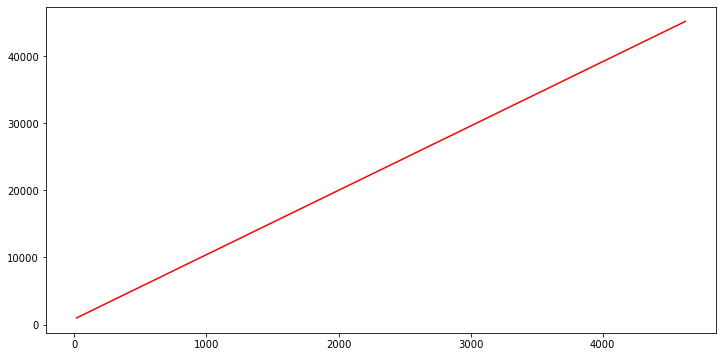

In [238]:
import matplotlib.pyplot as plt

reg = LinearRegression()
reg_result = reg.fit(X, y)


fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.sort(X.flatten()), regressHart(y, X, X)[np.argsort(X.flatten())], color='red')

[[ 1.01181221e+03  9.38809730e+00 -1.34507116e+00  1.28546426e-03]]
[[ 8.36476447e+02  9.58126583e+00 -1.34507014e+00  1.28546261e-03]]
[[ 8.36476546e+02  9.58126570e+00 -1.34506912e+00  1.28546096e-03]]


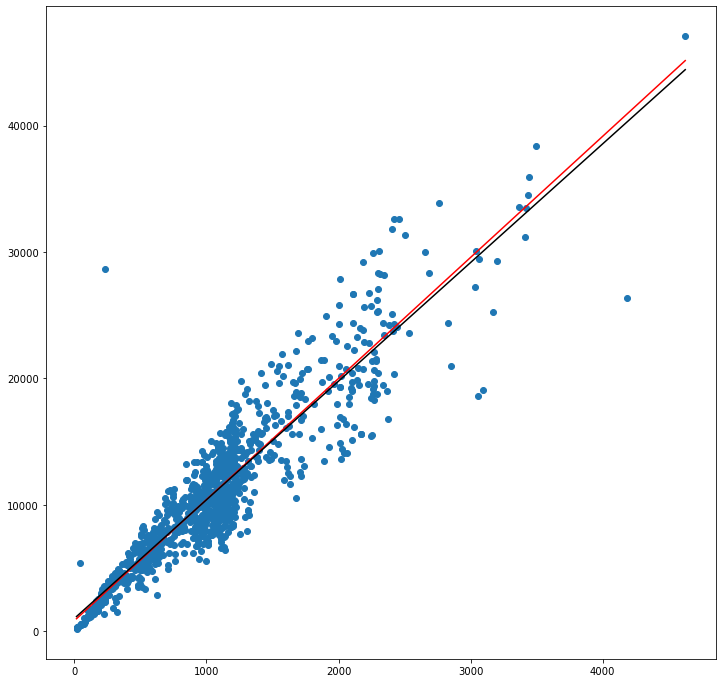

In [241]:
import matplotlib.pyplot as plt

reg = LinearRegression()
reg_result = reg.fit(X, y)


fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=X, y=y)
ax.plot(np.sort(X.flatten()), regressHart(y, X, X)[np.argsort(X.flatten())], color='red')
ax.plot(np.sort(X.flatten()), reg_result.predict(X)[np.argsort(X.flatten())], color='black')

In [244]:
X_df = pd.read_csv('X_train.csv')
y_df = pd.read_csv('y_train.csv')


X = X_df['building_size_m2'].values.reshape(-1, 1)
y = y_df['price_in_rp'].values

array([[105.],
       [ 80.],
       [ 95.],
       ...,
       [ 39.],
       [ 78.],
       [ 89.]])

In [251]:
weight

array([0.85712237, 0.9120942 , 0.88192076, ..., 0.96223985, 0.91554559,
       0.89494129])

[[-9.83918922e+08  2.66723628e+07 -4.09271062e+00  2.19154135e-02]]
[[-2.36062824e+08  1.83181981e+07 -4.09271062e+00  2.19154135e-02]]
[[-2.36062824e+08  1.83181981e+07 -4.09271062e+00  2.19154135e-02]]


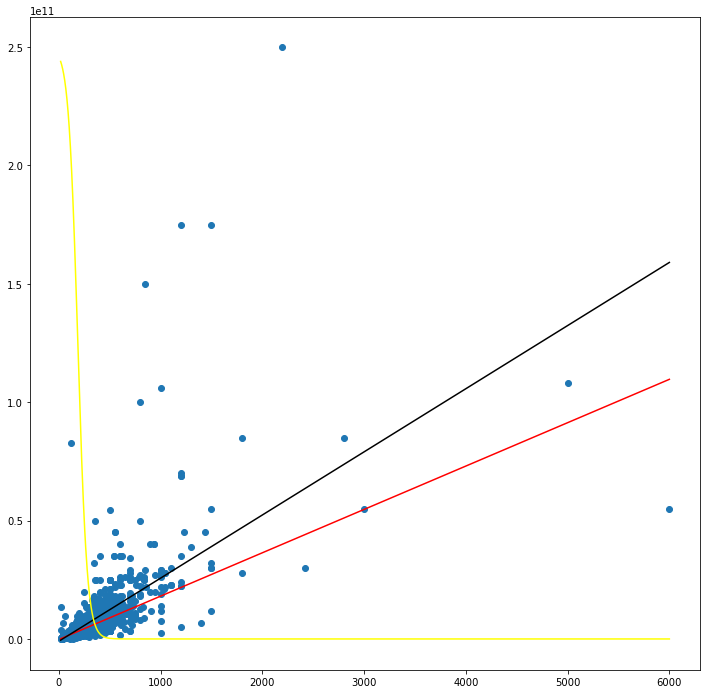

In [255]:
import matplotlib.pyplot as plt

X_df = pd.read_csv('X_train.csv')
y_df = pd.read_csv('y_train.csv')


X = X_df['building_size_m2'].values.reshape(-1, 1)
y = y_df['price_in_rp'].values

reg = LinearRegression()
reg_result = reg.fit(X, y)


fig, ax = plt.subplots(figsize=(12, 12))
weighted_y = weight * 2.5e11
ax.scatter(x=X, y=y)
ax.plot(np.sort(X.flatten()), regressHart(y, X, X)[np.argsort(X.flatten())], color='red')
ax.plot(np.sort(X.flatten()), reg_result.predict(X)[np.argsort(X.flatten())], color='black')
ax.plot(np.sort(X.flatten()), weighted_y[np.argsort(X.flatten())], color='yellow')

In [274]:
min(y)

125000000.0

In [246]:
def regressHart(y, X, Z, **kwargs):
    n = len(y)
    if n != X.shape[0]:
        raise ValueError('Size mismatch')
    maxiterdef = 10000
    toldef = 1e-12
    test=0
    options = dict(
        intercept=True,
        maxiter=maxiterdef,
        type='art',
        initialbeta=None, # shall be array of shape (n_features, ) for single target regression
        initialgamma=None,
        tol=toldef,
        nocheck=False,
        msgiter=0,
        test=test
    )
    test = options['test']
    reg = LinearRegression(fit_intercept=options['intercept'])
    # number of predictors
    if options['intercept']:
        p = X.shape[1] + 1
    else:
        p = X.shape[1]
    reg_results0 = reg.fit(X, y)
    b0 = np.c_[reg_results0.intercept_, reg_results0.coef_] # b0 is array of shape (n_features, ) for single target regression
    r = y - reg_results0.predict(X)
    oldbeta = b0
    sigma2 = r.T @ r / (n)
    # loglikelihood of residual
    logL_R = n * (1 + np.log(sigma2))
    #  Initialization of gamma
    #  Z = n-by-r matrix which contains the explanatory variables for
    #  heteroskedasticity
    Z_ = Z.copy
    # if options['intercept']:
    #     Z_ = add_constant(Z_)
    response_gamma0 = n * np.square(r) / np.sum(np.square(r)) - 1
    reg_gamma = reg.fit(Z, response_gamma0)
    gamma0 = np.c_[reg_gamma.intercept_, reg_gamma.coef_]
    # gamma
    oldgamma = gamma0
    # tolerance
    tol = options['tol']
    cont = 1
    iter = 0
    maxiter = options['maxiter']
    delt = 0.5
    th = 8
    dold = np.c_[oldbeta, oldgamma]
    print(f'{dold}')
    while (cont == 1) & (iter < maxiter):
        iter = iter + 1
        if options['intercept']:
            Zoldgamma = (np.c_[np.repeat(1, n), Z] @ oldgamma.T).flatten()
        # Zoldgamma[Zoldgamma < -th] = -th
        # Zoldgamma[Zoldgamma > th] = th
        expZgamma = np.exp(Zoldgamma)
        omegahat = 1 + expZgamma
        weight = np.power(omegahat, -1)
        sqrtweight = np.sqrt(weight)
        reg_new = reg.fit(X, y, sample_weight=weight)
        y_new = reg_new.predict(X)
        newbeta = np.c_[reg_new.intercept_, reg_new.coef_]
        newres2 = np.square(sqrtweight * (y - y_new))
        newsigma2 = np.sum(newres2) / (n)
        Qweights = expZgamma / (1 + expZgamma)
        Zq = Z * Qweights.reshape(-1, 1)
        newres2ori = y - y_new
        yq = newres2ori / (newsigma2 * (1 + expZgamma))
        reg_q = reg.fit(Zq, yq)
        gamma_q = np.c_[reg_q.intercept_, reg_q.coef_]
        newgamma = oldgamma + gamma_q * delt
        dnew = np.c_[newbeta, newgamma]
        print(f'{dnew}')
        if (np.sum(np.square(dnew - dold)) / np.sum(np.square(dold))) > tol:
            cont = 1
            oldgamma = newgamma
            dold=dnew
        else:
            cont = 0
    return weight

[[-9.83918922e+08  2.66723628e+07 -4.09271062e+00  2.19154135e-02]]
[[-2.36062824e+08  1.83181981e+07 -4.09271062e+00  2.19154135e-02]]
[[-2.36062824e+08  1.83181981e+07 -4.09271062e+00  2.19154135e-02]]
[[-9.83918922e+08  2.66723628e+07 -4.09271062e+00  2.19154135e-02]]
[[-2.36062824e+08  1.83181981e+07 -4.09271062e+00  2.19154135e-02]]
[[-2.36062824e+08  1.83181981e+07 -4.09271062e+00  2.19154135e-02]]


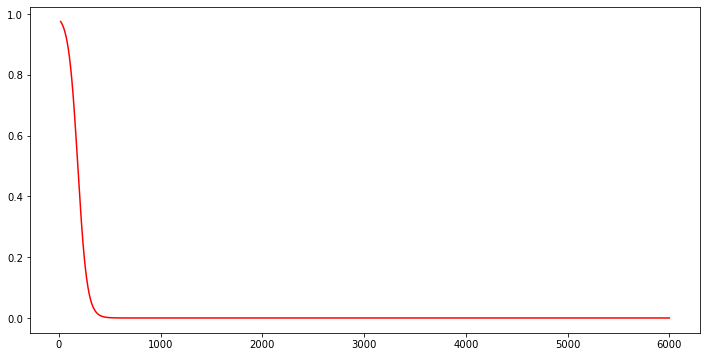

In [248]:
import matplotlib.pyplot as plt

reg = LinearRegression()
reg_result = reg.fit(X, y)


fig, ax = plt.subplots(figsize=(12, 6))
weight = regressHart(y, X, X)
ax.plot(np.sort(X.flatten()), regressHart(y, X, X)[np.argsort(X.flatten())], color='red')

In [271]:
def regressHart(y, X, Z, **kwargs):
    n = len(y)
    if n != X.shape[0]:
        raise ValueError('Size mismatch')
    maxiterdef = 10000
    toldef = 1e-12
    test=0
    options = dict(
        intercept=True,
        maxiter=maxiterdef,
        type='art',
        initialbeta=None, # shall be array of shape (n_features, ) for single target regression
        initialgamma=None,
        tol=toldef,
        nocheck=False,
        msgiter=0,
        test=test
    )
    test = options['test']
    reg = LinearRegression(fit_intercept=options['intercept'])
    # number of predictors
    if options['intercept']:
        p = X.shape[1] + 1
    else:
        p = X.shape[1]
    reg_results0 = reg.fit(X, y)
    b0 = np.c_[reg_results0.intercept_, reg_results0.coef_] # b0 is array of shape (n_features, ) for single target regression
    r = y - reg_results0.predict(X)
    oldbeta = b0
    sigma2 = r.T @ r / (n)
    # loglikelihood of residual
    logL_R = n * (1 + np.log(sigma2))
    #  Initialization of gamma
    #  Z = n-by-r matrix which contains the explanatory variables for
    #  heteroskedasticity
    Z_ = Z.copy
    # if options['intercept']:
    #     Z_ = add_constant(Z_)
    response_gamma0 = n * np.square(r) / np.sum(np.square(r)) - 1
    reg_gamma = reg.fit(Z, response_gamma0)
    gamma0 = np.c_[reg_gamma.intercept_, reg_gamma.coef_]
    # gamma
    oldgamma = gamma0
    # tolerance
    tol = options['tol']
    cont = 1
    iter = 0
    maxiter = options['maxiter']
    delt = 0.5
    th = 8
    dold = np.c_[oldbeta, oldgamma]
    print(f'{dold}')
    while (cont == 1) & (iter < maxiter):
        iter = iter + 1
        if options['intercept']:
            Zoldgamma = (np.c_[np.repeat(1, n), Z] @ oldgamma.T).flatten()
        # Zoldgamma[Zoldgamma < -th] = -th
        # Zoldgamma[Zoldgamma > th] = th
        expZgamma = np.exp(Zoldgamma)
        omegahat = 1 + expZgamma
        weight = np.power(omegahat, -1)
        sqrtweight = np.sqrt(weight)
        reg_new = reg.fit(X, y, sample_weight=weight)
        y_new = reg_new.predict(X)
        newbeta = np.c_[reg_new.intercept_, reg_new.coef_]
        newres2 = np.square(sqrtweight * (y - y_new))
        newsigma2 = np.sum(newres2) / (n)
        Qweights = expZgamma / (1 + expZgamma)
        Zq = Z * Qweights.reshape(-1, 1)
        newres2ori = y - y_new
        yq = newres2ori / (newsigma2 * (1 + expZgamma))
        reg_q = reg.fit(Zq, yq)
        gamma_q = np.c_[reg_q.intercept_, reg_q.coef_]
        newgamma = oldgamma + gamma_q * delt
        dnew = np.c_[newbeta, newgamma]
        print(f'{dnew}')
        if (np.sum(np.square(dnew - dold)) / np.sum(np.square(dold))) > tol:
            cont = 1
            oldgamma = newgamma
            dold=dnew
        else:
            cont = 0
    return reg_new.predict(np.array([500]).reshape(-1, 1))

In [273]:
y

array([1.98e+09, 9.50e+08, 1.05e+09, ..., 6.74e+08, 8.32e+08, 1.65e+09])

In [272]:
regressHart(y, X, X)

[[-9.83918922e+08  2.66723628e+07 -4.09271062e+00  2.19154135e-02]]
[[-2.36062824e+08  1.83181981e+07 -4.09271062e+00  2.19154135e-02]]
[[-2.36062824e+08  1.83181981e+07 -4.09271062e+00  2.19154135e-02]]


array([2.03585286e-12])